### Dữ liệu thô


### Dữ liệu đã làm sạch


In [14]:
!pip install pandas

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
    --------------------------------------- 0.3/11.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.3 MB 1.7 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.3 MB 1.6 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.3 MB 1.7 MB/s eta 0:00:06
   ------ --------------------------------- 1.8/11.3 MB 1.7 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.3 MB 1.7 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.3 MB 1.7 MB/s eta 0:00:06
   --------- ------------------------------ 2.6/11.3 MB 1.6 MB/s eta 0:00:06
   ----------- ---------------------------- 3.1/11.3 MB 1.6 MB/s eta 0:00:05
   ------------ --------------------------- 3.7/11.3 MB 1.7 MB/s eta 0:00:05
   -------------- ------------------------- 4.2/11.3 MB 1.8 MB/s eta 0:00:04
   ---------------- 

In [2]:
!pip install mne matplotlib numpy


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.4 MB 699.0 kB/s eta 0:00:10
   ---- ----------------------------------- 0.8/7.4 MB 798.0 kB/s eta 0:00:09
   ---- ----------------------------------- 0.8/7.4 MB 798.0 kB/s eta 0:00:09
   ---- ----------------------------------- 0.8/7.4 MB 798.0 kB/s eta 0:00:09
   ---- ----------------------------------- 0.8/7.4 MB 798.0 kB/s eta 0:00:09
   ----- ---------------------------------- 1.0/7.4 MB 529.6 kB/s eta 0:00:13
   ----- ---------------------------------- 1.0/7.4 MB 529.6 kB/s eta 0:00:13
   ----- ---------------------------------- 1.0/7.4 MB 529.6 kB/s eta 0:00:13
   ----- ------------------------------

In [15]:
# ==========================================
# 🧠 EEG Visualization Pipeline (10 .fif files)
# ==========================================
# Bước này giúp visualize tự động tất cả file EEG đã làm sạch.
# Hỗ trợ các loại dữ liệu: Raw, Epochs, Evoked, ICA
# ------------------------------------------

import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd


In [4]:
# === Cấu hình cơ bản ===
DATA_DIR = Path("./data")  # hoặc thư mục chứa 10 file .fif của bạn
OUT_DIR = Path("./plots")
OUT_DIR.mkdir(exist_ok=True)


In [5]:
# Lấy danh sách file .fif
fif_files = sorted(DATA_DIR.glob("*.fif"))
print(f"🔍 Tìm thấy {len(fif_files)} file FIF trong {DATA_DIR}:")
for f in fif_files:
    print(" -", f.name)


🔍 Tìm thấy 10 file FIF trong data:
 - sub-01_cleaned.fif
 - sub-03_cleaned.fif
 - sub-04_cleaned.fif
 - sub-05_cleaned.fif
 - sub-06_cleaned.fif
 - sub-08_cleaned.fif
 - sub-09_cleaned.fif
 - sub-11_cleaned.fif
 - sub-12_cleaned.fif
 - sub-13_cleaned.fif


In [6]:
# === Visualize ===
def visualize_fif(file_path: Path, out_dir: Path):
    print(f"\n🧩 Đang xử lý file: {file_path.name}")
    try:
        # 1️⃣ Thử đọc file dạng Raw
        raw = mne.io.read_raw_fif(file_path, preload=True, verbose="ERROR")
        print("➡️ Dạng dữ liệu: Raw (continuous EEG)")

        # --- Time-series (8 kênh đầu, 10 giây) ---
        picks = mne.pick_types(raw.info, eeg=True)[:8]
        if len(picks) == 0:
            picks = list(range(min(8, raw.info['nchan'])))
        sfreq = raw.info["sfreq"]
        data, times = raw[picks, :int(10 * sfreq)]

        fig, axes = plt.subplots(len(picks), 1, figsize=(10, 2.5 * len(picks)), sharex=True)
        ch_names = [raw.ch_names[p] for p in picks]
        for i, ax in enumerate(axes):
            ax.plot(times, data[i])
            ax.set_ylabel(ch_names[i])
        axes[-1].set_xlabel("Time (s)")
        fig.suptitle(f"EEG Time-series — {file_path.stem}")
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        ts_path = out_dir / f"{file_path.stem}_timeseries.png"
        fig.savefig(ts_path, dpi=150)
        plt.close(fig)
        print("   ✅ Saved:", ts_path.name)

        # --- PSD (Welch) ---
        psds, freqs = mne.time_frequency.psd_welch(
            raw, picks=picks, fmin=0.5, fmax=60.0, n_fft=2048, verbose="ERROR"
        )
        psds_db = 10 * np.log10(psds)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(psds_db.shape[0]):
            ax.semilogy(freqs, psds_db[i])
        ax.set_xlim(0.5, 60)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("PSD (dB/Hz)")
        ax.set_title(f"Power Spectral Density — {file_path.stem}")
        psd_path = out_dir / f"{file_path.stem}_psd.png"
        fig.tight_layout()
        fig.savefig(psd_path, dpi=150)
        plt.close(fig)
        print("   ✅ Saved:", psd_path.name)

        # --- Topomap (nếu có vị trí điện cực) ---
        try:
            fig = raw.plot_sensors(show_names=False)
            topo_path = out_dir / f"{file_path.stem}_topomap.png"
            fig.savefig(topo_path, dpi=150)
            plt.close(fig)
            print("   ✅ Saved:", topo_path.name)
        except Exception:
            print("   ⚠️ Không có vị trí điện cực — bỏ qua topomap.")

    except Exception:
        # 2️⃣ Thử đọc Epochs
        try:
            epochs = mne.read_epochs(file_path, preload=True, verbose="ERROR")
            print("➡️ Dạng dữ liệu: Epochs (đã cắt đoạn)")

            # Trung bình (evoked)
            evoked = epochs.average()
            fig = evoked.plot(show=False)
            avg_path = out_dir / f"{file_path.stem}_average.png"
            fig.savefig(avg_path, dpi=150)
            plt.close(fig)
            print("   ✅ Saved:", avg_path.name)

            # Ảnh epochs đầu tiên
            fig = epochs.plot_image(picks=[0], show=False)
            img_path = out_dir / f"{file_path.stem}_epoch_image.png"
            fig.savefig(img_path, dpi=150)
            plt.close(fig)
            print("   ✅ Saved:", img_path.name)

        except Exception:
            # 3️⃣ Thử đọc Evoked
            try:
                evokeds = mne.read_evokeds(file_path, verbose="ERROR")
                print("➡️ Dạng dữ liệu: Evoked (trung bình phản ứng)")

                for idx, ev in enumerate(evokeds):
                    fig = ev.plot(show=False)
                    ev_path = out_dir / f"{file_path.stem}_evoked_{idx}.png"
                    fig.savefig(ev_path, dpi=150)
                    plt.close(fig)
                    print("   ✅ Saved:", ev_path.name)
            except Exception as e:
                print(f"❌ Không thể đọc file {file_path.name}. Lỗi: {e}")



🧩 Đang xử lý file: sub-01_cleaned.fif
➡️ Dạng dữ liệu: Epochs (đã cắt đoạn)
   ✅ Saved: sub-01_cleaned_average.png
Not setting metadata
536 matching events found
No baseline correction applied
0 projection items activated
➡️ Dạng dữ liệu: Evoked (trung bình phản ứng)

🧩 Đang xử lý file: sub-03_cleaned.fif
➡️ Dạng dữ liệu: Epochs (đã cắt đoạn)
   ✅ Saved: sub-03_cleaned_average.png
Not setting metadata
628 matching events found
No baseline correction applied
0 projection items activated
➡️ Dạng dữ liệu: Evoked (trung bình phản ứng)

🧩 Đang xử lý file: sub-04_cleaned.fif
➡️ Dạng dữ liệu: Epochs (đã cắt đoạn)
   ✅ Saved: sub-04_cleaned_average.png
Not setting metadata
608 matching events found
No baseline correction applied
0 projection items activated
➡️ Dạng dữ liệu: Evoked (trung bình phản ứng)

🧩 Đang xử lý file: sub-05_cleaned.fif
➡️ Dạng dữ liệu: Epochs (đã cắt đoạn)
   ✅ Saved: sub-05_cleaned_average.png
Not setting metadata
629 matching events found
No baseline correction applied

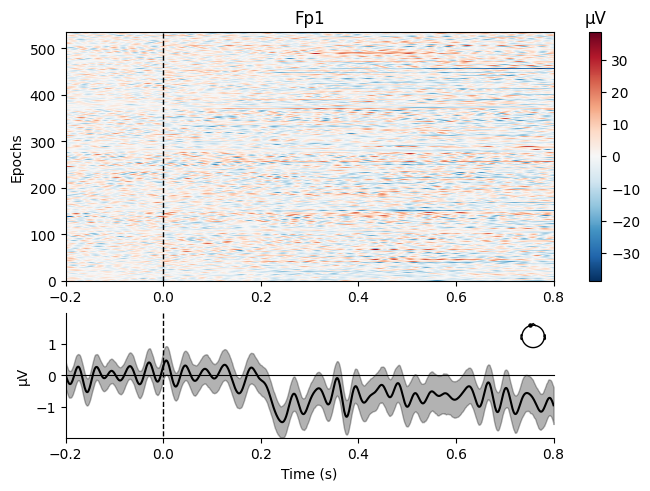

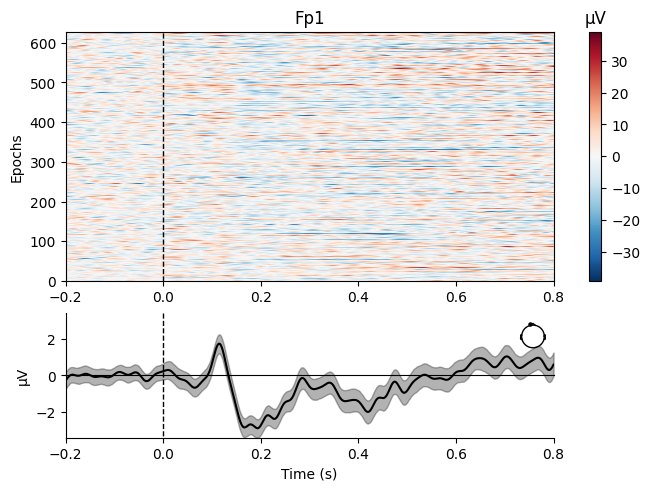

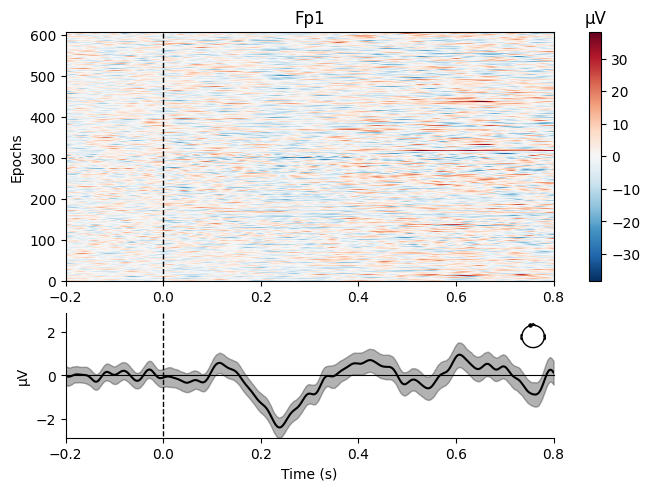

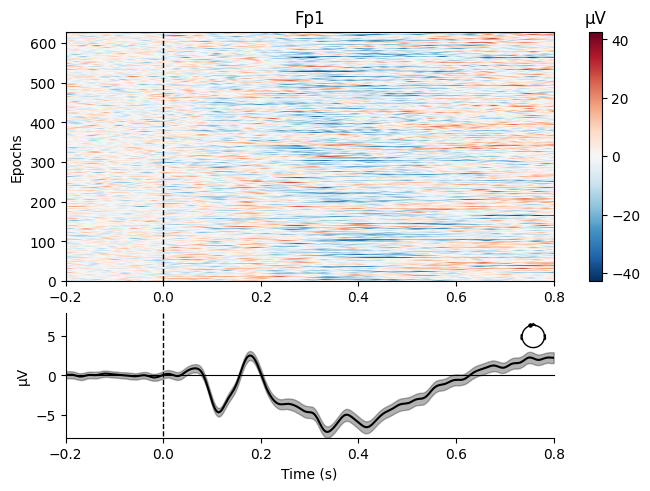

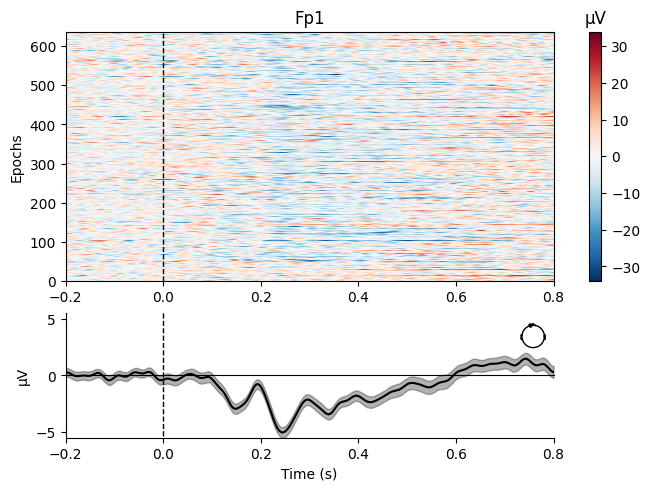

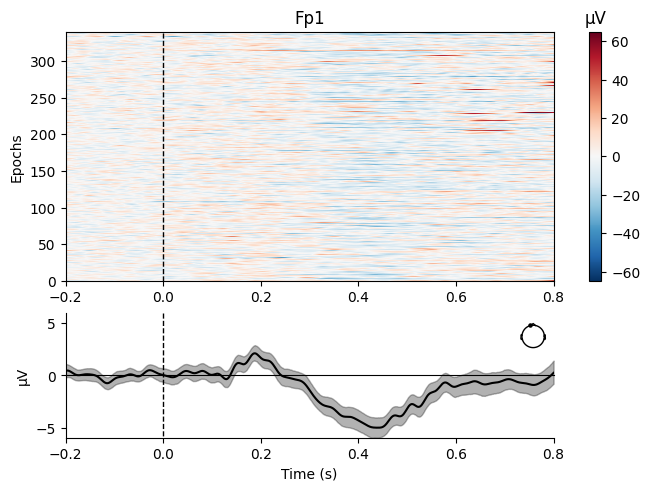

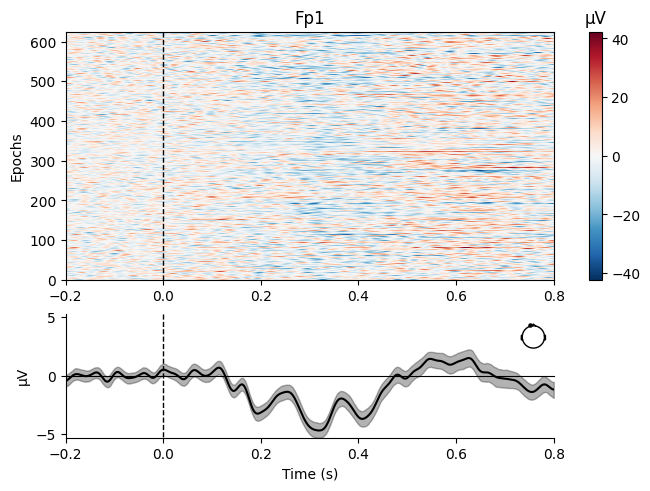

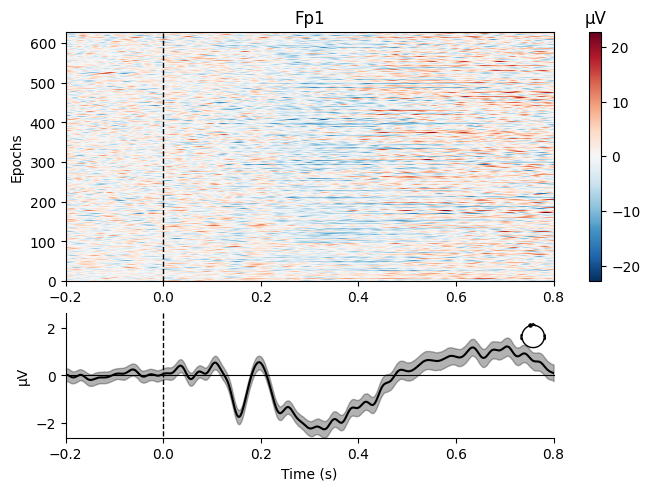

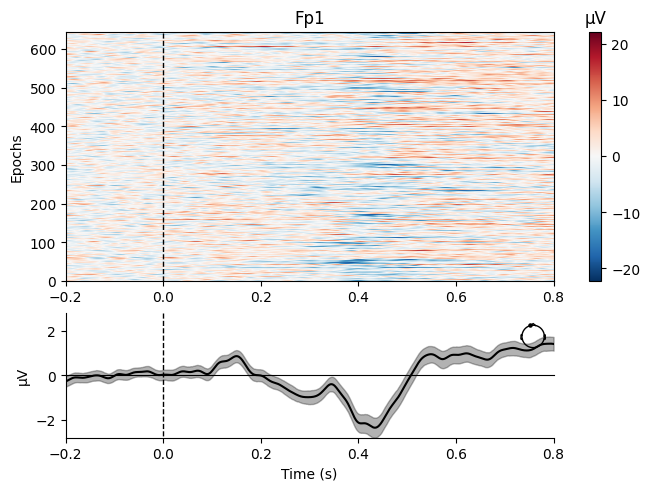

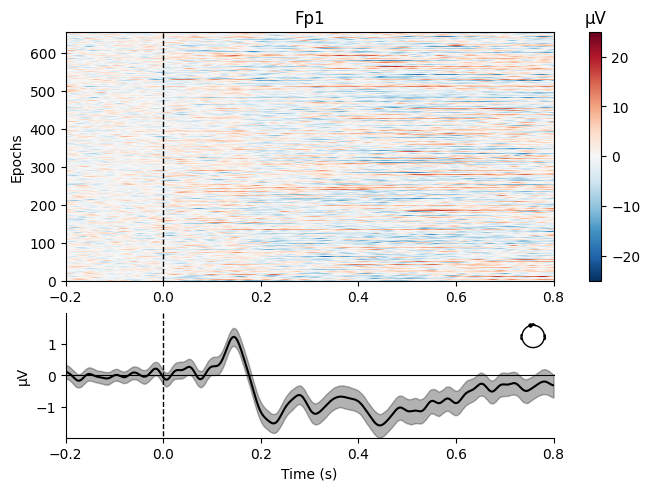

In [7]:
# === Vòng lặp visualize tất cả 10 file ===
for f in fif_files:
    visualize_fif(f, OUT_DIR)

print("\n🎨 Hoàn tất! Tất cả ảnh đã lưu trong thư mục:", OUT_DIR.resolve())


### Dữ liệu trích suất

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đọc dữ liệu
df = pd.read_csv("data/features.csv")
print("Số dòng:", len(df))
print("Số cột:", len(df.columns))
df.head(3)


Số dòng: 4669
Số cột: 724


,subject_id,trial_id,label,AF3_alpha_log_power,AF3_beta_log_power,AF3_delta_log_power,AF3_mean_amp,AF3_peak_amp,AF3_peak_lat,AF3_theta_log_power,...,TPP7h_peak_amp,TPP7h_peak_lat,TPP7h_theta_log_power,TPP8h_alpha_log_power,TPP8h_beta_log_power,TPP8h_delta_log_power,TPP8h_mean_amp,TPP8h_peak_amp,TPP8h_peak_lat,TPP8h_theta_log_power
0,sub-03,0,1,-13.213906,-12.694797,-12.015079,-0.000007,-7.144108e-08,0.418,-12.273278,...,0.000002,0.309,-12.225700,-11.927724,-12.437134,-11.480321,-3.992515e-06,0.000010,0.463,-11.852953
1,sub-03,1,0,-12.829155,-13.013405,-12.242465,0.000002,8.422218e-06,0.560,-12.265361,...,0.000010,0.430,-11.230701,-11.969571,-12.316622,-11.712483,-7.286959e-07,0.000009,0.429,-11.694240
2,sub-03,2,0,-12.392271,-12.831872,-12.171232,0.000003,6.386965e-06,0.456,-12.213064,...,0.000024,0.568,-11.999837,-11.981506,-12.157160,-11.583211,1.157716e-05,0.000021,0.575,-11.814481


### So sánh theo nhãn

C:\Users\neo\AppData\Local\Temp\ipykernel_43464\1827569590.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="alpha_mean", palette="Set2")


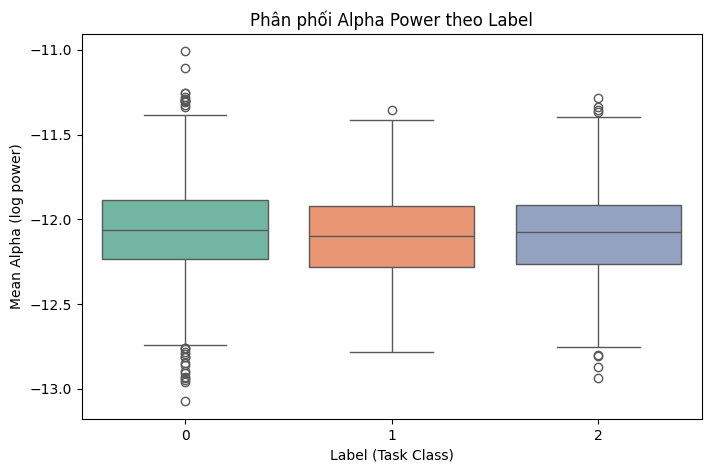

In [6]:
# Lấy trung bình alpha, beta, theta theo toàn bộ kênh
bands = ['alpha', 'beta', 'theta', 'delta']
for band in bands:
    cols = [c for c in df.columns if f"{band}_log_power" in c]
    df[f"{band}_mean"] = df[cols].mean(axis=1)

# Boxplot theo label
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="label", y="alpha_mean", palette="Set2")
plt.title("Phân phối Alpha Power theo Label")
plt.xlabel("Label (Task Class)")
plt.ylabel("Mean Alpha (log power)")
plt.show()


### Correlation heatmap

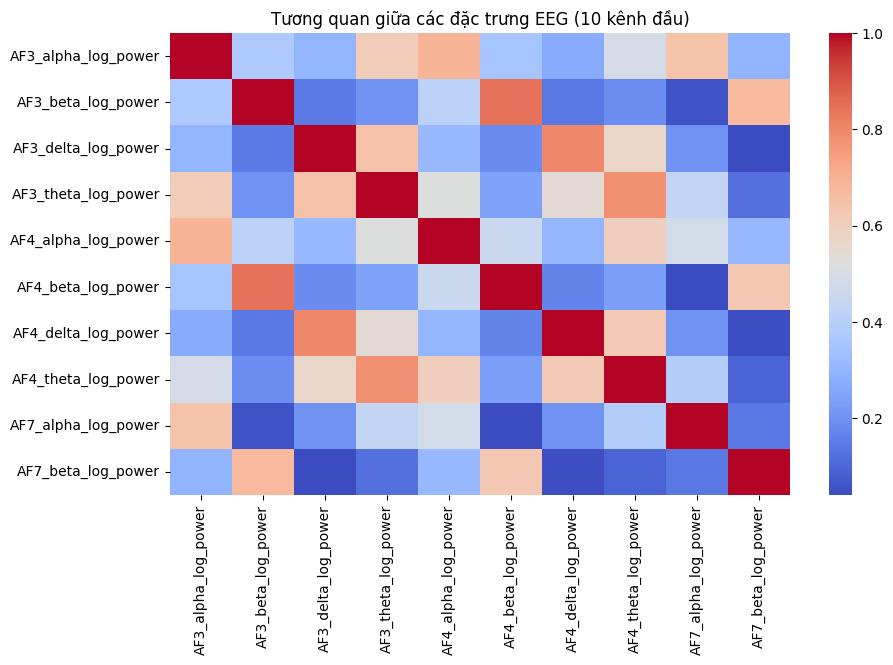

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df[[c for c in df.columns if "log_power" in c]].corr().abs().iloc[:10, :10], cmap="coolwarm")
plt.title("Tương quan giữa các đặc trưng EEG (10 kênh đầu)")
plt.show()


### Topomap

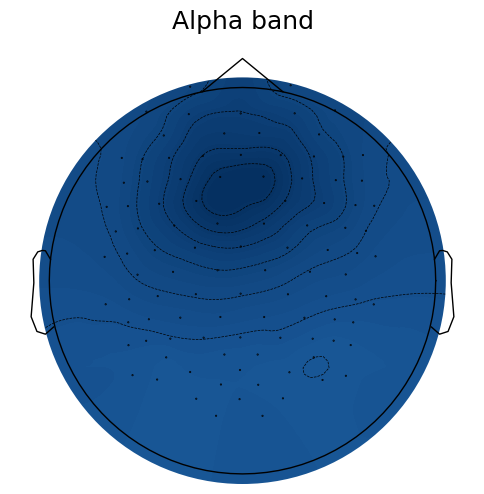

In [12]:
# ======================================================
# 🧠 Topomap lớn + đẹp (band power) — Cách 3 mở rộng
# ======================================================
import mne
import numpy as np
import matplotlib.pyplot as plt

band = 'alpha'   # đổi thành: 'beta', 'theta', 'delta'

# 1) Lấy trung bình band power theo từng kênh EEG
mean_band = {}
for col in [c for c in df.columns if c.endswith(f"{band}_log_power")]:
    ch_name = col.split("_")[0]
    mean_band[ch_name] = df[col].mean()

# 2) Load standard_1005 montage
montage = mne.channels.make_standard_montage("standard_1005")

# 3) Lọc kênh hợp lệ
valid_chs = []
valid_vals = []

for ch, val in mean_band.items():
    if ch in montage.ch_names:
        valid_chs.append(ch)
        valid_vals.append(val)

# 4) Tạo EvokedArray
data = np.array(valid_vals).reshape(len(valid_vals), 1)
info = mne.create_info(valid_chs, sfreq=250, ch_types='eeg')
evk = mne.EvokedArray(data, info)
evk.set_montage(montage)

# 5) Plot topomap lớn
fig, ax = plt.subplots(figsize=(6, 6))  # 👉 tăng kích thước figure
mne.viz.plot_topomap(
    data[:, 0],
    evk.info,
    axes=ax,
    cmap="RdBu_r",
    show=False,
    contours=6,
    sensors=True,
    sphere=0.1
)

ax.set_title(f"{band.capitalize()} band", fontsize=18)

plt.show()

# LƯU PNG DPI CAO
fig.savefig(f"{band}_topomap.png", dpi=300, bbox_inches='tight')


✔ Số kênh có vị trí: 59 / 103


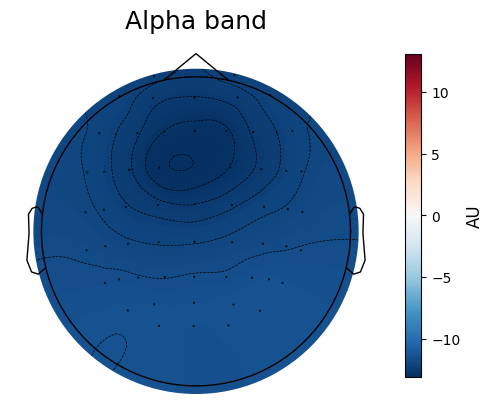

In [13]:
import mne
import numpy as np
import matplotlib.pyplot as plt

band = 'alpha'  # chọn band

# 1) Lấy trung bình band power theo từng kênh
mean_band = {}
for col in [c for c in df.columns if c.endswith(f"{band}_log_power")]:
    ch = col.split("_")[0] 
    mean_band[ch] = df[col].mean()

# 2) Load montage chuẩn
montage = mne.channels.make_standard_montage("standard_1020")

# 3) Lọc kênh hợp lệ (có vị trí)
valid_ch = []
valid_vals = []

for ch, val in mean_band.items():
    if ch in montage.ch_names:
        valid_ch.append(ch)
        valid_vals.append(val)

print(f"✔ Số kênh có vị trí: {len(valid_ch)} / {len(mean_band)}")

# 4) Tạo EvokedArray
data = np.array(valid_vals).reshape(len(valid_vals), 1)
info = mne.create_info(valid_ch, sfreq=250, ch_types='eeg')
evk = mne.EvokedArray(data, info)
evk.set_montage(montage)

# 5) Vẽ TOPOMAP + COLORBAR
fig, ax = plt.subplots(figsize=(6, 6))

# Plot topomap → trả về im object để làm colorbar
im, cn = mne.viz.plot_topomap(
    data[:, 0],
    evk.info,
    axes=ax,
    cmap="RdBu_r",
    sensors=True,
    contours=6,
    show=False,
    sphere=0.1
)

ax.set_title(f"{band.capitalize()} band", fontsize=18)

# Tạo colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("AU", fontsize=12)

plt.show()


In [15]:
!pip install scikit-learn


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 2.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/8.9 MB 1.9 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/8.9 MB 1.8 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/8.9 MB 1.8 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.9 MB 1.4 MB/s eta 0:00:06
   --------- ------------------------------ 2.1/8.9 MB 1.5 MB/s eta 0:00:05
   ---------- ----------------------------- 2.4/8.9 MB 1.5 MB/s eta 0:00:05
   ----------- ---------------------------- 2.6/8.9 MB 1.5 MB/s eta 0:00:05
   -------------- ------------------------- 3.1/8.9 MB 1.6 MB/s eta 0:00:04
   ---------------- ----------------------- 3.7/8.9 MB 1.6 MB/s eta 0:00:04
   ----------------- ---------------------- 3.9/8.9 MB 1.6 MB/s eta 0:00:04
   ------------------ ----

### PCA Visualization

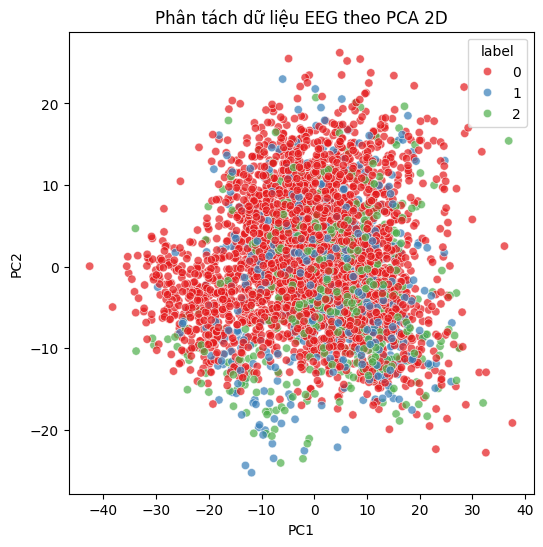

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df[[c for c in df.columns if "log_power" in c]]
y = df["label"]

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', alpha=0.7)
plt.title("Phân tách dữ liệu EEG theo PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


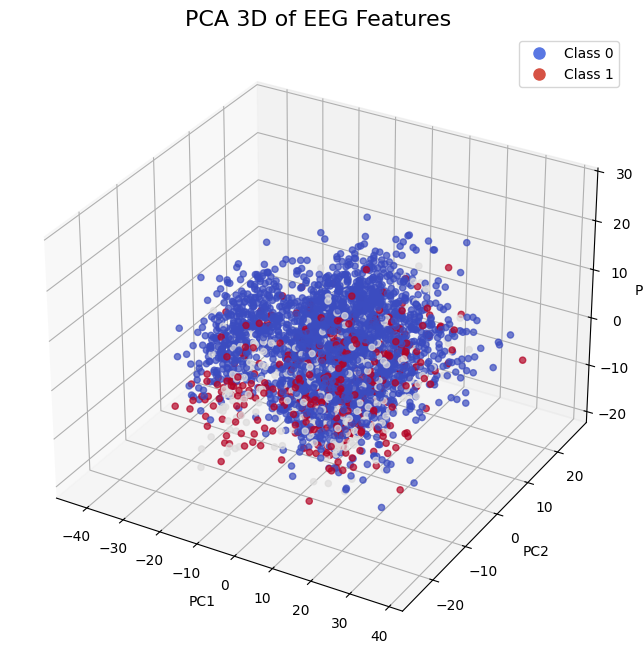

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 1. Chọn tất cả feature log_power
X = df[[c for c in df.columns if "log_power" in c]].values
y = df["label"].values

# 2. Chuẩn hóa
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 3. PCA 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)

# 4. Vẽ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    X_pca[:, 2],
    c=y, 
    cmap="coolwarm", 
    alpha=0.7,
    s=20
)

ax.set_title("PCA 3D of EEG Features", fontsize=16)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Thêm legend cho label
legend_labels = ['Class 0', 'Class 1']
legend_colors = [plt.cm.coolwarm(0.1), plt.cm.coolwarm(0.9)]
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8)
           for color in legend_colors]
ax.legend(handles, legend_labels, loc="best")

plt.show()
